<header style="padding:1px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Insurance Analysis Using Temporal</b>
</header>


<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Introduction</b></p>

<p style = 'font-size:18px;font-family:Arial'>
Applications require to design and build databases dependant on time or data changes over time.  Building such applications is possible but becomes easier with Temporal
   
</p>  

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'> <b>WHY TEMPORAL? </b> </p>

<p style = 'font-size:18px;font-family:Arial'>    
Things You No Longer Have To Do in the Time-Aware Teradata Database
Data Maintenance : </p>
    
<li style = 'font-size:16px;font-family:Arial'> Update effective dates in data.</li></<li style = 'font-size:16px;font-family:Arial'> <li style = 'font-size:16px;font-family:Arial'> Specify “transaction time” timestamp when data are entered or updated. </li>
<li style = 'font-size:16px;font-family:Arial'> Insert new data rows for updates. </li>     
<li style = 'font-size:16px;font-family:Arial'> Manage temporal history storage space. </li> 
  

 
<p style = 'font-size:18px;font-family:Arial'> Query and Application Development : </p>


<li style = 'font-size:16px;font-family:Arial'> Write complex period based condition clauses. </li>
<li style = 'font-size:16px;font-family:Arial'> Add effective date qualifications to “current queries.” </li>
<li style = 'font-size:16px;font-family:Arial'> Train users and application developers in effective date columns and processing for “AS OF” query development.</li>
<li style = 'font-size:16px;font-family:Arial'> Save old reports or database snapshots to facilitate looking backfor analysis, compliance reporting, or audit trails.</li>

<p style = 'font-size:16px;font-family:Arial'>Here we are considering the example of Insurance company storing data for various policies whose validity, conditions , premium amount and many other factors will change over Time period.</p>
    
    
 

   
    
    
    
<p style = 'font-size:18px;font-family:Arial'>Some scenarios that can be handled using temporal features are as below 
    
<li style = 'font-size:16px;font-family:Arial'>    Consider the scenario where there is a hail storm occuring on a particular date. The As of date feature can be used to check the validity of the policy and than the incident date can be used to check which claims fall in the validity period of the policies.</li>
    
<li style = 'font-size:16px;font-family:Arial'>    Another scenario is that the customer has sold the vehicle and the closure of the policy happened a week late as the customer informed late about the sale , so based on the transaction time the validity of the policies will change. </li>



    
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'> <b>Accessing the Data </b></p>
<p style = 'font-size:16px;font-family:Arial'>These demos will work either with foreign tables accessed from Cloud Storage via NOS or you may import the tables to your machine. If you import data for multiple demos, you may need to use the Data Dictionary "Manage Your Space" routine to cleanup tables you no longer need. 
    
<p style = 'font-size:16px;font-family:Arial'>Use the link below to access the 2 options for using data from the data dictionary notebook:    
    
    
[Click Here to get data for this notebook](../Data_Dictionary/Data_Dictionary.ipynb#TRNG_InsuranceClaims)    
    
    
[Click Here to Manage Your Space](../Data_Dictionary/Data_Dictionary.ipynb#Manage_Your_Space)
    

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'> <b>Let's start by connecting to the Teradata system </b></p>

In [1]:
%connect local


Password: ···


Success: 'local' connection established and activated for user 'demo_user'


<p style = 'font-size:16px;font-family:Arial'>Consider scenario where we have to check all valid policies whose validity period is similar to the Policy of the Mercedes -ML350 in the state IL. In a table without the temporal columns the query would look like the below : </p>

In [2]:
select b.Policy_id, b.Customer_id, b.auto_make , b.Policy_start_date,b.Policy_end_date
from TRNG_InsuranceClaims.policy_details_org a
, TRNG_InsuranceClaims.policy_details_org b
where a.auto_make = 'Mercedes'
and a.policy_state = 'IL'
and a.auto_model = 'ML350'
and a.policy_state = b.Policy_state
AND a.policy_start_date <= b.policy_start_date
AND a.policy_end_date > b.policy_start_date
AND a.policy_end_date <= b.policy_end_date
UNION ALL
select b.Policy_id, b.Customer_id, b.auto_make , b.Policy_start_date,b.Policy_end_date
from TRNG_InsuranceClaims.policy_details_org a
, TRNG_InsuranceClaims.policy_details_org b
where a.auto_make = 'Mercedes'
and a.policy_state = 'IL'
and a.auto_model = 'ML350'
and a.policy_state = b.Policy_state
AND a.policy_start_date <= b.policy_start_date
AND a.policy_end_date >= b.policy_end_date
UNION ALL
select b.Policy_id, b.Customer_id, b.auto_make , b.Policy_start_date,b.Policy_end_date
from TRNG_InsuranceClaims.policy_details_org a
, TRNG_InsuranceClaims.policy_details_org b
where a.auto_make = 'Mercedes'
and a.policy_state = 'IL'
and a.auto_model = 'ML350'
and a.policy_state = b.Policy_state
AND a.policy_start_date >= b.policy_start_date
AND a.policy_end_date <= b.policy_end_date
UNION ALL
select b.Policy_id, b.Customer_id, b.auto_make , b.Policy_start_date,b.Policy_end_date
from TRNG_InsuranceClaims.policy_details_org a
, TRNG_InsuranceClaims.policy_details_org b
where a.auto_make = 'Mercedes'
and a.policy_state = 'IL'
and a.auto_model = 'ML350'
and a.policy_state = b.Policy_state
AND a.policy_start_date >= b.policy_start_date
AND a.policy_start_date < b.policy_end_date
AND a.policy_end_date >= b.policy_end_date;

,Policy_ID,Customer_ID,auto_make,Policy_start_date,Policy_end_date
1,596790,4781149,Accura,2015-09-04,2020-09-04
2,596790,4781149,Accura,2015-09-04,2020-09-04
3,596790,4781149,Accura,2015-09-04,2020-09-04
4,596790,4781149,Accura,2015-09-04,2020-09-04
5,596790,4781149,Accura,2015-09-04,2020-09-04
6,596790,4781149,Accura,2015-09-04,2020-09-04
7,596790,4781149,Accura,2015-09-04,2020-09-04
8,596790,4781149,Accura,2015-09-04,2020-09-04
9,596790,4781149,Accura,2015-09-04,2020-09-04
10,596790,4781149,Accura,2015-09-04,2020-09-04


<p style = 'font-size:16px;font-family:Arial'>Use the Temporal ValidTime function to display similar results as the query written above on table without Period datatype. </p>

In [3]:
Validtime select b.Policy_id, b.Customer_id, b.auto_make 
from TRNG_InsuranceClaims.policy_details a , TRNG_InsuranceClaims.policy_details b
where a.auto_make = 'Mercedes'
and a.policy_state = 'IL'
and a.auto_model = 'ML350'
and a.policy_state = b.Policy_state
;

,Policy_ID,Customer_ID,auto_make,VALIDTIME
1,369786,2645288,Saab,"2011-11-25,2012-01-22"
2,241562,7017277,Accura,"2011-01-28,2012-01-22"
3,722747,5900891,Suburu,"2011-09-02,2012-01-22"
4,515222,6447002,BMW,"2011-01-22,2011-12-18"
5,369786,2645288,Saab,"2011-11-25,2012-01-22"
6,241562,7017277,Accura,"2011-01-22,2011-01-28"
7,722747,5900891,Suburu,"2011-09-02,2012-01-22"
8,515222,6447002,BMW,"2011-12-18,2012-01-22"
9,533940,4585664,Audi,"2011-11-18,2012-01-22"
10,976650,5128749,Ford,"2011-01-22,2011-08-28"


<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'> <b>Comparison for Queries with and without Temporal </b></p>

<table>
<tr>
<td style="color:black;font-size:18px;font-weight:bold">WITH TEMPORAL</td>
<td style="color:black;font-size:18px;font-weight:bold">WITHOUT TEMPORAL</td> 
</tr>

<tr>
<td>Validtime select b.Policy_id, b.Customer_id, b.auto_make from policy_details a , policy_details b where a.auto_make = 'Mercedes' and a.policy_state = 'IL' and a.auto_model = 'ML350' and a.policy_state = b.Policy_state; </td>
<td>select b.Policy_id, b.Customer_id, b.auto_make , b.Policy_start_date,b.Policy_end_date from policy_details_org_extrapolate a , policy_details_org_extrapolate b where a.auto_make = 'Mercedes' and a.policy_state = 'IL' and a.auto_model = 'ML350' and a.policy_state = b.Policy_state AND a.policy_start_date b.policy_start_date AND a.policy_end_date    UNION ALL 
select b.Policy_id, b.Customer_id, b.auto_make , b.Policy_start_date,b.Policy_end_date from policy_details_org_extrapolate a , policy_details_org_extrapolate b where a.auto_make = 'Mercedes' and a.policy_state = 'IL' and a.auto_model = 'ML350' and a.policy_state = b.Policy_state AND a.policy_start_date <= b.policy_start_date AND a.policy_end_date >= b.policy_end_date

   UNION ALL 
select b.Policy_id, b.Customer_id, b.auto_make , b.Policy_start_date,b.Policy_end_date from policy_details_org_extrapolate a , policy_details_org_extrapolate b where a.auto_make = 'Mercedes' and a.policy_state = 'IL' and a.auto_model = 'ML350' and a.policy_state = b.Policy_state AND a.policy_start_date >= b.policy_start_date AND a.policy_end_date <= b.policy_end_date

   UNION ALL
select b.Policy_id, b.Customer_id, b.auto_make , b.Policy_start_date,b.Policy_end_date from policy_details_org_extrapolate a , policy_details_org_extrapolate b where a.auto_make = 'Mercedes' and a.policy_state = 'IL' and a.auto_model = 'ML350' and a.policy_state = b.Policy_state AND a.policy_start_date >= b.policy_start_date AND a.policy_start_date < b.policy_end_date AND a.policy_end_date >= b.policy_end_date;</td>
</tr>    
</table>    
 

 <p style = 'font-size:18px;font-family:Arial;'> <b>Performance Comparison for above queries </b> </p>

 <img src="images/PerformanceMetrics.png" style="width:1000px;height:200px;">

<p style = 'font-size:16px;font-family:Arial'>Comparing the Validity and VALIDTIME columns demonstrates that the   
    valid-time period of the result set is the intersection of the valid-time period in the original Policy table Validity 
    column with the Period specified in the sequenced select statement.</p>


In [4]:
SEQUENCED VALIDTIME PERIOD '(2009-01-01, 2009-12-31)'
SELECT Policy_ID, Customer_ID, Policy_Validity FROM (
SEQUENCED VALIDTIME SELECT Policy_details.*
FROM TRNG_InsuranceClaims.Policy_Details where policy_state = 'IN') AS my_derived_table;


,Policy_ID,Customer_ID,Policy_Validity,VALIDTIME
1,237423,1133354,"2008-06-04,2009-06-04","2009-01-01,2009-06-04"
2,550132,3964730,"2008-01-04,2009-01-04","2009-01-01,2009-01-04"
3,332897,2540822,"2008-04-25,2009-04-25","2009-01-01,2009-04-25"
4,535879,8040359,"2009-03-05,2010-03-05","2009-03-05,2009-12-31"
5,853360,7409287,"2009-06-26,2010-06-26","2009-06-26,2009-12-31"
6,582973,8045031,"2008-06-11,2009-06-11","2009-01-01,2009-06-11"
7,615121,7625391,"2009-05-09,2010-05-09","2009-05-09,2009-12-31"
8,866936,4627650,"2008-07-07,2009-07-07","2009-01-01,2009-07-07"
9,250833,7877784,"2008-07-28,2009-07-28","2009-01-01,2009-07-28"
10,913464,6446834,"2009-01-21,2010-01-21","2009-01-21,2009-12-31"


<p style = 'font-size:16px;font-family:Arial'>Aggregations can be used for analysis of the data based on the validity period. 
Comparisons of data between different validity periods can be achieved with Temporal. Like the minimum and maximum premium amounts for a particular state based on the model of the cars.</p>



In [5]:
SEQUENCED VALIDTIME Period (date '2011-01-01', date '2020-12-31')
SELECT auto_make,
min(Policy_premium_Amt) as MinPremium,
max(Policy_premium_Amt) as MaxPremium
FROM TRNG_InsuranceClaims.Policy_Details
where policy_state = 'OH'
GROUP BY 1
ORDER BY VALIDTIME;



,auto_make,MinPremium,MaxPremium,VALIDTIME
1,Honda,1203,1453,"2011-01-01,2011-01-06"
2,Suburu,1038,1088,"2011-01-01,2011-01-12"
3,Mercedes,667,1783,"2011-01-01,2011-01-24"
4,Audi,1050,1714,"2011-01-01,2011-01-28"
5,Accura,1489,1489,"2011-01-01,2011-02-02"
6,BMW,1052,1307,"2011-01-01,2011-02-03"
7,Jeep,830,880,"2011-01-01,2011-02-11"
8,Toyota,1338,1338,"2011-01-01,2011-02-21"
9,Saab,1484,1539,"2011-01-01,2011-03-11"
10,Dodge,998,1305,"2011-01-01,2011-03-17"


<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'> <b>Temporal concepts </b></p>

<p style = 'font-size:18px;font-family:Arial'> <b> Time line for various Policies :-    Analysis can be done for </b> </p>
    
   
<li style = 'font-size:16px;font-family:Arial'>Policies valid during a particular period.</li>
    
<li style = 'font-size:16px;font-family:Arial'>Validity period of various policies.</li>
    
<li style = 'font-size:16px;font-family:Arial'>Premium amount collected during a particular period </li>

<p style = 'font-size:18px;font-family:Arial'>Using the As Of concept to verify the active policies on a particular date</p>

<p style = 'font-size:16px;font-family:Arial'>On a given date, there was a hail storm and we want to determine the count of policies in effect on that date
The scenario mentioned here can be solved by the below query using the As of Date feature of Temporal tables   
 </p>


<img src="images/TemporalTimePeriod.png" style="width:600px;height:400px;">



In [6]:
VALIDTIME AS OF Date'2022-02-15'
SELECT Policy_ID, Customer_ID, Policy_premium_Amt,Policy_Validity FROM TRNG_InsuranceClaims.Policy_Details where policy_state = 'IL'

,Policy_ID,Customer_ID,Policy_premium_Amt,Policy_Validity
1,369786,2645288,1316,"2017-11-25,2022-11-25"
2,241562,7017277,2197,"2021-01-28,9999-12-31"
3,722747,5900891,1582,"2017-09-02,2022-09-02"
4,596790,4781149,1254,"2020-09-04,9999-12-31"
5,533940,4585664,1456,"2017-11-18,2022-11-18"
6,976650,5128749,1247,"2021-08-28,9999-12-31"
7,369048,8120451,1627,"2017-06-05,2022-06-05"
8,596790,4781149,1254,"2020-09-04,2025-09-04"
9,490601,6986977,1348,"2017-08-04,2022-08-04"
10,787351,5940419,1830,"2019-04-28,9999-12-31"


In [7]:
Select count(*) as "no of Policies" from (VALIDTIME AS OF Date'2022-02-15'
SELECT Policy_ID, Customer_ID, Policy_premium_Amt,Policy_Validity FROM TRNG_InsuranceClaims.Policy_Details where policy_state = 'IL') as DerivTbl

,no of Policies
1,367


<p style = 'font-size:16px;font-family:Arial'>Consider scenario where we need to check that for a particular period(here for year 2021) how many policies are valid for each auto make type and then compare the no of policies which are valid in the current period. This helps us in the comparision in the increase or decrease of policies for the current year as compared to the past year of validity
 </p>


In [8]:
Select auto_make,count(*) as "no of Policies" from (VALIDTIME Period (date'2021-01-01',date'2021-12-31')
SELECT Policy_ID, Customer_ID, Policy_premium_Amt,auto_make FROM TRNG_InsuranceClaims.Policy_Details ) as DerivTbl group by 1

,auto_make,no of Policies
1,Chevrolet,23
2,Honda,13
3,Mercedes,10
4,Ford,28
5,Suburu,21
6,Volkswagen,28
7,Dodge,27
8,Accura,30
9,Saab,50
10,Audi,46


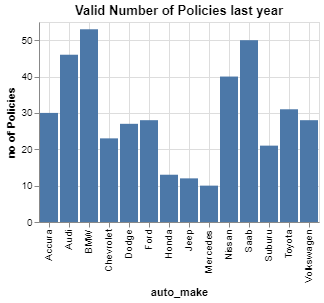

In [9]:
%chart x=auto_make, y="no of Policies", title= Valid Number of Policies last year 

<p style = 'font-size:16px;font-family:Arial'>Now we check how many policies are still valid for each type using the current functionality
 </p>


In [10]:
Select auto_make,count(*) as "no of Policies" from (current VALIDTIME 
SELECT Policy_ID, Customer_ID, Policy_premium_Amt,auto_make FROM TRNG_InsuranceClaims.Policy_Details ) as DerivTbl group by 1

,auto_make,no of Policies
1,Chevrolet,23
2,Honda,12
3,Mercedes,8
4,Ford,22
5,Suburu,20
6,Volkswagen,27
7,Dodge,25
8,Accura,26
9,Saab,47
10,Audi,41


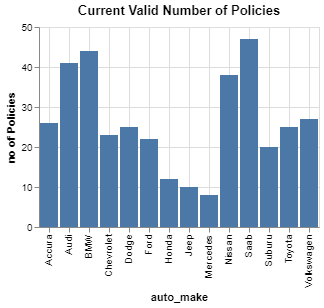

In [11]:
%chart x=auto_make, y="no of Policies", title= Current Valid Number of Policies  

<p style = 'font-size:16px;font-family:Arial'>In this scenario we are considering that there are a number of claims raised against policies on various incident dates. Below queries help to identify which claims made are in the validity period and which are not and which policies are valid at the time of the incidents.There are total 69 claims in the Insurance Claims tables and based on the incident date we can verify which claims are valid and which are not valid.
 </p>


In [12]:
SELECT * from TRNG_InsuranceClaims.Insurance_Claims_Details;


,Policy_id,Claim_id,Incident_date,claim_date,Claim_amount
1,369786,43626,2017-12-03,2022-10-29,2432
2,241562,72468,2016-02-14,2020-12-27,1393
3,722747,56816,2017-09-01,2022-08-14,2361
4,515222,53026,2016-12-16,2021-12-17,1225
5,533940,76670,2017-11-18,2022-11-06,379
6,976650,12901,2016-09-01,2021-08-04,2286
7,369048,25158,2017-06-13,2022-06-03,1896
8,212585,16771,2016-01-09,2020-12-27,1074
9,490601,15676,2017-07-31,2022-06-26,1999
10,235869,77765,2017-01-25,2021-12-25,2987


<p style = 'font-size:16px;font-family:Arial'>Based on the Claims made , we need to validate which claims are valid on the incident date mentioned. Below query helps in the analysis. Only the rows that qualify for the claims are displayed.
 </p>


In [13]:
SELECT  'Valid Claims' as ClaimType , Policy.customer_id,Policy.Policy_id, Insurance_Claims_Details.Claim_Id, Claim_amount
FROM (current VALIDTIME SELECT Policy_Details.* FROM TRNG_InsuranceClaims.Policy_Details )Policy
INNER JOIN TRNG_InsuranceClaims.Insurance_Claims_Details ON Policy.Policy_id = Insurance_Claims_Details.Policy_id
WHERE Policy.Policy_Validity CONTAINS Insurance_Claims_Details.Incident_date
;


,ClaimType,Customer_ID,Policy_ID,Claim_id,Claim_amount
1,Valid Claims,2645288,369786,43626,2432
2,Valid Claims,3309391,420948,38224,1588
3,Valid Claims,7273220,998870,78211,1628
4,Valid Claims,8369854,212585,16771,1074
5,Valid Claims,4585664,533940,76670,379
6,Valid Claims,3309391,420948,21449,1968
7,Valid Claims,7273220,998870,21823,2417
8,Valid Claims,8369854,212585,56225,1146
9,Valid Claims,1529583,987529,69690,433
10,Valid Claims,6136627,425636,12950,979


<p style = 'font-size:16px;font-family:Arial'>Below query displays the Invalid rows from Claims table
 </p>


In [14]:
SELECT customer_id,Policy.Policy_id, Claim_Id, Claim_amount
from TRNG_InsuranceClaims.Insurance_Claims_Details INNER JOIN TRNG_InsuranceClaims.Policy_Details Policy
ON Policy.Policy_id = Insurance_Claims_Details.Policy_id
MINUS
SELECT Policy.customer_id,Policy.Policy_id, Insurance_Claims_Details.Claim_Id, Claim_amount
FROM (current VALIDTIME SELECT Policy_Details.* FROM TRNG_InsuranceClaims.Policy_Details )Policy
INNER JOIN TRNG_InsuranceClaims.Insurance_Claims_Details ON Policy.Policy_id = Insurance_Claims_Details.Policy_id
WHERE Policy.Policy_Validity CONTAINS Insurance_Claims_Details.Incident_date;


,Customer_ID,Policy_ID,Claim_id,Claim_amount
1,2660358,444422,81186,1613
2,4169839,231513,67781,2311
3,7017277,241562,72468,1393
4,6901083,932502,78245,1714
5,3048175,651866,44033,1852
6,5703051,171152,39298,1386
7,3311113,469874,35990,786
8,5350490,694662,69669,2859
9,1285244,735307,54723,1715
10,7902640,132876,19159,1519


<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'> <b>Explaining the Temporal Concepts of Inserts /Deletes </b></p> 

<p style = 'font-size:16px;font-family:Arial'>Customer 1 has policy 1 with Validity Period . In between the validity period the customer decides to change some factors which causes the premium to increase , so there will be a new addition which will insert a new row having validity period from changed date to the end of period. </p>
    
    
    
<p style = 'font-size:16px;font-family:Arial'>Customer 2 has Policy 1 with validity period. In between the company decides to increase the premium which also increases the validity period.
 </p>


<img src="images/Temporal_Inserts_Updates.png" style="width:600px;height:400px;">



<p style = 'font-size:18px;font-family:Arial'>Inserting data into temporal table is simple for current validtime. </p>

In [15]:
current validtime Insert TRNG_InsuranceClaims_DB.TRNG_InsuranceClaims_Policy_Det values (203914, 2316038,'OH'  ,1200,'Audi','A3')

Success: 1 rows affected

<p style = 'font-size:18px;font-family:Arial'>Inserting history rows will need Temporal Qualifier. </p>

In [16]:
sequenced validtime Insert TRNG_InsuranceClaims_DB.TRNG_InsuranceClaims_Policy_Det values (203914, 2316038,'OH'  ,1050,'Audi','A3' ,PERIOD(date'2002-06-10', date'2012-06-09'));
sequenced validtime Insert TRNG_InsuranceClaims_DB.TRNG_InsuranceClaims_Policy_Det values (203914, 2316038,'OH'  ,1150,'Audi','A3' ,PERIOD(date'2012-06-10', date'2022-06-27'));


Success: 1 rows affected

Success: 1 rows affected

In [17]:
sequenced validtime select * from TRNG_InsuranceClaims.Policy_Details where customer_id = 2316038 order by validtime;

,Policy_ID,Customer_ID,Policy_State,Policy_premium_Amt,auto_make,auto_model,Policy_Validity,VALIDTIME
1,203914,2316038,OH,1000,Audi,A3,"2001-06-09,2002-06-09","2001-06-09,2002-06-09"
2,203914,2316038,OH,1050,Audi,A3,"2002-06-10,2012-06-09","2002-06-10,2012-06-09"
3,203914,2316038,OH,1050,Audi,A3,"2002-06-10,2012-06-09","2002-06-10,2012-06-09"
4,203914,2316038,OH,1150,Audi,A3,"2012-06-10,2022-06-27","2012-06-10,2022-06-27"
5,203914,2316038,OH,1150,Audi,A3,"2012-06-10,2022-06-27","2012-06-10,2022-06-27"
6,203914,2316038,OH,1200,Audi,A3,"2022-06-28,9999-12-31","2022-06-28,9999-12-31"
7,203914,2316038,OH,1200,Audi,A3,"2022-11-09,9999-12-31","2022-11-09,9999-12-31"


<p style = 'font-size:16px;font-family:Arial'>Without Temporal Qualifier the select will display only current row. </p>

In [18]:
----SET SESSION CURRENT VALIDTIME;
 

Success: 0 rows affected

In [19]:
select * from TRNG_InsuranceClaims.Policy_Details where customer_id = 2316038 order by Policy_validity;

,Policy_ID,Customer_ID,Policy_State,Policy_premium_Amt,auto_make,auto_model,Policy_Validity,VALIDTIME
1,203914,2316038,OH,1000,Audi,A3,"2001-06-09,2002-06-09","2001-06-09,2002-06-09"
2,203914,2316038,OH,1050,Audi,A3,"2002-06-10,2012-06-09","2002-06-10,2012-06-09"
3,203914,2316038,OH,1050,Audi,A3,"2002-06-10,2012-06-09","2002-06-10,2012-06-09"
4,203914,2316038,OH,1150,Audi,A3,"2012-06-10,2022-06-27","2012-06-10,2022-06-27"
5,203914,2316038,OH,1150,Audi,A3,"2012-06-10,2022-06-27","2012-06-10,2022-06-27"
6,203914,2316038,OH,1200,Audi,A3,"2022-06-28,9999-12-31","2022-06-28,9999-12-31"
7,203914,2316038,OH,1200,Audi,A3,"2022-11-09,9999-12-31","2022-11-09,9999-12-31"


<p style = 'font-size:16px;font-family:Arial'>When period is specified , Delete will only delete rows for that specific period (highlighted row in the above dataset) and the validity period for rows will change to the end of period specified in the delete. </p> 

<p style = 'font-size:16px;font-family:Arial'>Display rows for Specific Valid Period.</p>

In [20]:
SEQUENCED VALIDTIME PERIOD '(1990-01-01, 1990-03-31)' SELECT * 
FROM TRNG_InsuranceClaims.Policy_details where policy_state = 'IN' order by validtime;


,Policy_ID,Customer_ID,Policy_State,Policy_premium_Amt,auto_make,auto_model,Policy_Validity,VALIDTIME
1,529112,1965883,IN,1240,Honda,Civic,"1990-01-30,1991-01-08","1990-01-30,1990-03-31"
2,171183,3976603,IN,671,Ford,Escape,"1990-02-01,1991-02-01","1990-02-01,1990-03-31"
3,598554,7535602,IN,795,Nissan,Maxima,"1990-02-14,1991-02-14","1990-02-14,1990-03-31"
4,728025,4414390,IN,1935,Mercedes,E400,"1990-02-15,1991-02-15","1990-02-15,1990-03-31"


<p style = 'font-size:16px;font-family:Arial'>Delete rows for Specific Valid Period will change the validity period to the end date specified in delete. </p>

In [21]:
SEQUENCED VALIDTIME PERIOD '(1990-01-01, 1990-01-30)' DELETE
FROM TRNG_InsuranceClaims_DB.TRNG_InsuranceClaims_Policy_Det where policy_state = 'IN';


Success: 0 rows affected

In [22]:
SEQUENCED VALIDTIME PERIOD '(1990-01-01, 1990-03-31)' SELECT * 
FROM TRNG_InsuranceClaims_DB.TRNG_InsuranceClaims_Policy_Det where policy_state = 'IN' order by validtime;

,Policy_ID,Customer_ID,Policy_State,Policy_premium_Amt,auto_make,auto_model,VALIDTIME
1,529112,1965883,IN,1240,Honda,Civic,"1990-01-30,1990-03-31"
2,171183,3976603,IN,671,Ford,Escape,"1990-02-01,1990-03-31"
3,598554,7535602,IN,795,Nissan,Maxima,"1990-02-14,1990-03-31"
4,728025,4414390,IN,1935,Mercedes,E400,"1990-02-15,1990-03-31"


<p style = 'font-size:18px;font-family:Arial'> <b>Usage of Bi Temporal Table with ValidTime and TransactionTime Columns.</b> </p>

<p style = 'font-size:16px;font-family:Arial'>Select data for a particular range of data temporal features need to be added to the select. </b>

In [23]:
sequenced validtime and transactiontime as of current_timestamp
sel * from TRNG_InsuranceClaims.Policy_Bitemp

,Policy_ID,Customer_ID,Policy_State,Policy_premium_Amt,auto_make,auto_model,Policy_Validity,Policy_Duration,VALIDTIME
1,361834,7025216,OH,1071,Dodge,RAM,"1995-03-17,1996-03-17","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","1995-03-17,1996-03-17"
2,602704,1948931,OH,1189,Jeep,Wrangler,"2011-09-27,2012-09-27","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2011-09-27,2012-09-27"
3,208303,1976899,OH,823,Mercedes,E400,"1991-05-03,1992-05-03","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","1991-05-03,1992-05-03"
4,524215,5721194,OH,951,Accura,RSX,"1990-06-24,1991-06-24","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","1990-06-24,1991-06-24"
5,270213,8652582,OH,1596,Volkswagen,Jetta,"2005-02-09,2006-02-09","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2005-02-09,2006-02-09"
6,886478,5136692,OH,1472,Accura,MDX,"1991-09-10,1992-09-10","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","1991-09-10,1992-09-10"
7,498847,6063829,OH,1255,Accura,RSX,"2000-11-04,2001-11-04","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2000-11-04,2001-11-04"
8,193213,6073310,OH,1250,Ford,Escape,"1996-03-11,1997-03-11","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","1996-03-11,1997-03-11"
9,284834,5173281,OH,1664,Audi,A3,"2009-08-03,2010-08-03","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2009-08-03,2010-08-03"
10,221191,6007236,OH,1567,BMW,X5,"2005-02-13,2006-02-13","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2005-02-13,2006-02-13"


<p style = 'font-size:16px;font-family:Arial'>Updating the Policy amount will also change the transaction time for the policies. </b>

In [24]:
UPDATE TRNG_InsuranceClaims_DB.TRNG_InsuranceClaims_Policy_Bitemp
SET Policy_premium_Amt = Policy_premium_Amt + 10
WHERE policy_id in (
361834
,602704
,208303
,524215)


Success: 4 rows affected

In [25]:
sequenced validtime and current transactiontime
sel * from TRNG_InsuranceClaims.Policy_Bitemp

,Policy_ID,Customer_ID,Policy_State,Policy_premium_Amt,auto_make,auto_model,Policy_Validity,Policy_Duration,VALIDTIME
1,361834,7025216,OH,1081,Dodge,RAM,"1995-03-17,1996-03-17","2022-11-09 23:42:47.290000-05:00,9999-12-31 23:59:59.999999+00:00","1995-03-17,1996-03-17"
2,602704,1948931,OH,1199,Jeep,Wrangler,"2011-09-27,2012-09-27","2022-11-09 23:42:47.290000-05:00,9999-12-31 23:59:59.999999+00:00","2011-09-27,2012-09-27"
3,208303,1976899,OH,833,Mercedes,E400,"1991-05-03,1992-05-03","2022-11-09 23:42:47.290000-05:00,9999-12-31 23:59:59.999999+00:00","1991-05-03,1992-05-03"
4,524215,5721194,OH,961,Accura,RSX,"1990-06-24,1991-06-24","2022-11-09 23:42:47.290000-05:00,9999-12-31 23:59:59.999999+00:00","1990-06-24,1991-06-24"
5,270213,8652582,OH,1596,Volkswagen,Jetta,"2005-02-09,2006-02-09","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2005-02-09,2006-02-09"
6,886478,5136692,OH,1472,Accura,MDX,"1991-09-10,1992-09-10","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","1991-09-10,1992-09-10"
7,498847,6063829,OH,1255,Accura,RSX,"2000-11-04,2001-11-04","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2000-11-04,2001-11-04"
8,193213,6073310,OH,1250,Ford,Escape,"1996-03-11,1997-03-11","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","1996-03-11,1997-03-11"
9,284834,5173281,OH,1664,Audi,A3,"2009-08-03,2010-08-03","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2009-08-03,2010-08-03"
10,221191,6007236,OH,1567,BMW,X5,"2005-02-13,2006-02-13","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2005-02-13,2006-02-13"


<p style = 'font-size:16px;font-family:Arial'>Consider the scenario when the validity changes a week later than the actual date which causes changes in the current validity </p>

In [26]:
Current Validtime
UPDATE TRNG_InsuranceClaims_DB.TRNG_InsuranceClaims_Policy_Bitemp
SET Policy_premium_Amt =  Policy_premium_Amt
WHERE policy_id in (686821
)


Success: 0 rows affected

In [27]:
sequenced validtime and current transactiontime
sel * from TRNG_InsuranceClaims.Policy_Bitemp

,Policy_ID,Customer_ID,Policy_State,Policy_premium_Amt,auto_make,auto_model,Policy_Validity,Policy_Duration,VALIDTIME
1,361834,7025216,OH,1081,Dodge,RAM,"1995-03-17,1996-03-17","2022-11-09 23:42:47.290000-05:00,9999-12-31 23:59:59.999999+00:00","1995-03-17,1996-03-17"
2,602704,1948931,OH,1199,Jeep,Wrangler,"2011-09-27,2012-09-27","2022-11-09 23:42:47.290000-05:00,9999-12-31 23:59:59.999999+00:00","2011-09-27,2012-09-27"
3,208303,1976899,OH,833,Mercedes,E400,"1991-05-03,1992-05-03","2022-11-09 23:42:47.290000-05:00,9999-12-31 23:59:59.999999+00:00","1991-05-03,1992-05-03"
4,524215,5721194,OH,961,Accura,RSX,"1990-06-24,1991-06-24","2022-11-09 23:42:47.290000-05:00,9999-12-31 23:59:59.999999+00:00","1990-06-24,1991-06-24"
5,270213,8652582,OH,1596,Volkswagen,Jetta,"2005-02-09,2006-02-09","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2005-02-09,2006-02-09"
6,886478,5136692,OH,1472,Accura,MDX,"1991-09-10,1992-09-10","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","1991-09-10,1992-09-10"
7,498847,6063829,OH,1255,Accura,RSX,"2000-11-04,2001-11-04","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2000-11-04,2001-11-04"
8,193213,6073310,OH,1250,Ford,Escape,"1996-03-11,1997-03-11","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","1996-03-11,1997-03-11"
9,284834,5173281,OH,1664,Audi,A3,"2009-08-03,2010-08-03","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2009-08-03,2010-08-03"
10,221191,6007236,OH,1567,BMW,X5,"2005-02-13,2006-02-13","2022-11-09 23:42:15.510000-05:00,9999-12-31 23:59:59.999999+00:00","2005-02-13,2006-02-13"


<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'> <b>CleanUp </b></p>

In [28]:
drop view TRNG_InsuranceClaims.Policy_Details_org;

Success: 14 rows affected

In [29]:
drop view TRNG_InsuranceClaims.Policy_Details;

Success: 14 rows affected

In [30]:
drop view TRNG_InsuranceClaims.Insurance_Claims_Details;

Success: 11 rows affected

In [31]:
drop view TRNG_InsuranceClaims.Policy_Bitemp;

Success: 16 rows affected

In [32]:
drop table TRNG_InsuranceClaims_DB.TRNG_InsuranceClaims_Policy_Det;

Success: 22 rows affected

In [33]:
drop table TRNG_InsuranceClaims_DB.TRNG_InsuranceClaims_Details;

Success: 19 rows affected

In [34]:
drop table TRNG_InsuranceClaims_DB.TRNG_InsuranceClaims_Policy_Bitemp;

Success: 25 rows affected

In [35]:
drop table gs_tables_db.TRNG_InsuranceClaims_PolicyDet_org;

Success: 28 rows affected

In [36]:
drop database TRNG_InsuranceClaims;

Success: 111 rows affected

In [37]:
drop database TRNG_InsuranceClaims_DB;

Success: 73 rows affected

</h4>
<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Reference Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Information about Temporal datatype can be found at: <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Temporal-Table-Support/July-2021'>https://docs.teradata.com/r/Teradata-VantageTM-Temporal-Table-Support/July-2021</a></li>
</ul>



<footer style="paddinga:10px;background:#f9f9f9;border-bottom:3px solid #394851">Copyright © Teradata Corporation - 2023. All Rights Reserved.</footer>